In [1]:
# import internal files
from historymatch import emulators
from historymatch import sample
from historymatch import historymatch
from historymatch import plot


# import external modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
import pandas as pd
import importlib
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import sklearn.linear_model as skl

plt.rcParams.update({'font.size': 10})

np.random.seed(4)

In [2]:
# import data

with open("data/MassEval2016.dat",'r') as infile:
    Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11,12),
              names=('N', 'Z', 'A', 'Element', 'Ebinding', 'E_unc'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=64,
              index_col=False)
    
# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
Masses['E_unc'] = pd.to_numeric(Masses['E_unc'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000
Masses['E_unc'] /= 1000

# Group the DataFrame by nucleon number, A.
Masses = Masses.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
Masses = Masses.apply(lambda t: t[t.Ebinding==t.Ebinding.max()])

A = Masses['A'].to_numpy()
Z = Masses['Z'].to_numpy()
N = Masses['N'].to_numpy()
Element = Masses['Element'].to_numpy()
Energies = Masses['Ebinding'].to_numpy()

Energies_A = Masses['Ebinding'].to_numpy()

#Energies_unc = Masses['E_unc'].to_numpy()
Energies_unc = Masses['E_unc'].to_numpy()

In [3]:
ndim = 5

In [4]:
# define parameter space

theta_0_bound = np.array([0, 6]).reshape(1,-1)
theta_1_bound = np.array([-1, 0.3]).reshape(1,-1)
theta_2_bound = np.array([0, 1.2]).reshape(1,-1)
theta_3_bound = np.array([0, 0.2]).reshape(1,-1) # keep
theta_4_bound = np.array([0, 0.5]).reshape(1,-1)

parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound, \
                                   theta_2_bound, theta_3_bound, theta_4_bound), axis=0)

theta_0_vals = np.linspace(parameter_bounds[0,0], parameter_bounds[0,1], 100)
theta_1_vals = np.linspace(parameter_bounds[1,0], parameter_bounds[1,1], 100)
theta_2_vals = np.linspace(parameter_bounds[2,0], parameter_bounds[2,1], 100)
theta_3_vals = np.linspace(parameter_bounds[3,0], parameter_bounds[3,1], 100)
theta_4_vals = np.linspace(parameter_bounds[4,0], parameter_bounds[4,1], 100)


theta_vals = np.concatenate((theta_0_vals.reshape(1,-1), theta_1_vals.reshape(1,-1), theta_2_vals.reshape(1,-1), theta_3_vals.reshape(1,-1), theta_4_vals.reshape(1,-1)), axis=0)


In [5]:
def LiquidDropModel(a0, a1, a2, a3, a4, A, Z, N):
    
    return a0 + a1*A + a2*(A**(2.0/3.0)) + a3*Z*(Z-1)*(A**(-1.0/3.0)) \
                + a4*((N-Z)**2)/A

true_parameters = [4.74783699, -0.20173376,  0.94655788,  0.00783107,  0.32286627]

In [6]:
variance = np.mean(Energies_unc)
print(variance)

1.1713178294573644e-05


In [7]:
# Now we set up the design matrix X
X = np.zeros((len(A),5))
X[:,0] = np.ones_like(A)
X[:,1] = A
X[:,2] = A**(2.0/3.0)
X[:,3] = Z*(Z-1) * A**(-1.0/3.0)
X[:,4] = (N-Z)**2 * A**(-1.0)

In [8]:
def A_matrix(X_d, variance):
    for i in range(X_d.shape[0]):
        X_d[i] = X_d[i] / np.sqrt(variance)
    return X_d

In [9]:
A1 = A_matrix(X, variance)
b1 = Energies_A / np.sqrt(variance)

In [10]:
def solve_theta(A, b):
    theta_best = ((np.linalg.inv(A.T.dot(A))).dot(A.T)).dot(b)
    return theta_best.flatten()

In [11]:
theta = solve_theta(A1, b1)
print(theta)

[ 4.74783699 -0.20173376  0.94655788  0.00783107  0.32286627]


In [12]:
def H_matrix(A):
    return np.linalg.inv(A.T.dot(A))

def covariance(X_d, variance):
    return variance*np.linalg.inv(X_d.T.dot(X_d))

In [13]:
H1 = H_matrix(A1)
cov_matrix = covariance(X, variance)

In [14]:
def get_cov_ellipse(cov, centre, nstd, ax, color):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """

    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * nstd * np.sqrt(np.abs(eigvals))
    
    t = np.linspace(0, 2*np.pi, 100)
    Ell = np.array([0.5*width*np.cos(t) , 0.5*height*np.sin(t)]) 
    R_rot = np.array([[np.cos(theta) , -np.sin(theta)],[np.sin(theta), np.cos(theta)]])  
    Ell_rot = np.zeros((2,Ell.shape[1]))
    for i in range(Ell.shape[1]):
        Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])
    
    ax.plot( centre[0]+Ell_rot[0,:] , centre[1]+Ell_rot[1,:], color=color)
    #ax.plot(Ell_rot[:,0], Ell_rot[:,1])

In [15]:
def plot_ellipses(fig, parameter_bounds, true_parameters, H, theta_best, theta_vals, color):
    theta_names = [r'$a_{0}$', r'$a_{1}$', r'$a_{2}$', r'$a_{3}$', r'$a_{4}$']
    N = len(theta_best)
    for i in range(N):
        for j in range(N):
            ax = fig.axes[i + N*j]
            if i != 0:
                ax.axes.yaxis.set_visible(False)
                
            if i == j:
                ax_right = ax.twinx()
                ax_right.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], theta_best[i], np.sqrt(H[i,i])), color=color)
                ax_right.set_title(str(theta_names[i]) + '=' + str(round(theta_best[i], 2)), fontsize=14)
                
            elif i < j:
                
                cov_matrix = np.array([[H[i,i], H[i,j]],[H[j,i], H[j,j]]])
                get_cov_ellipse(cov_matrix, [theta_best[i], theta_best[j]], 3, ax, color)
                ax.set_ylabel(theta_names[j])
                ax.set_xlabel(theta_names[i])
                #ax.set_xlim([parameter_bounds[i,0], parameter_bounds[i,1]])
                #zax.set_ylim([parameter_bounds[j,0], parameter_bounds[j,1]])
                
            else:
                ax.axis('off')

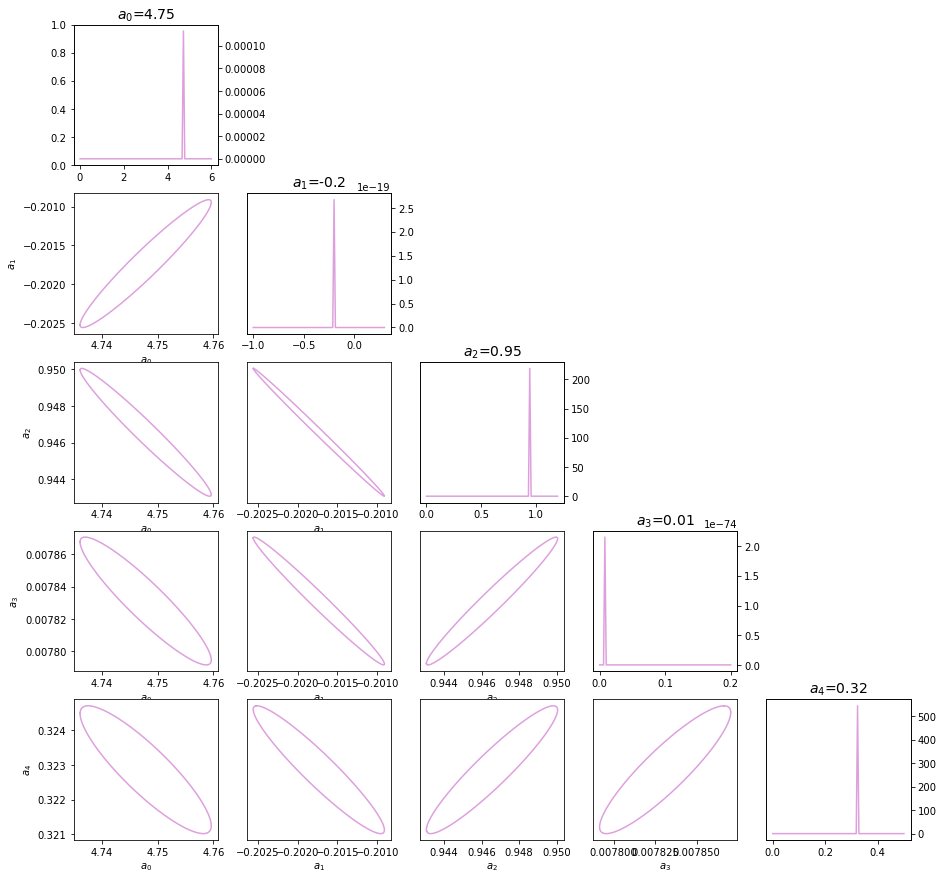

In [16]:
color_list = ['plum', 'mediumaquamarine', 'red']
N = ndim
fig, axes = plt.subplots(N,N,figsize=(15,15))

plot_ellipses(fig, parameter_bounds, true_parameters, H1, theta, theta_vals, color_list[0])

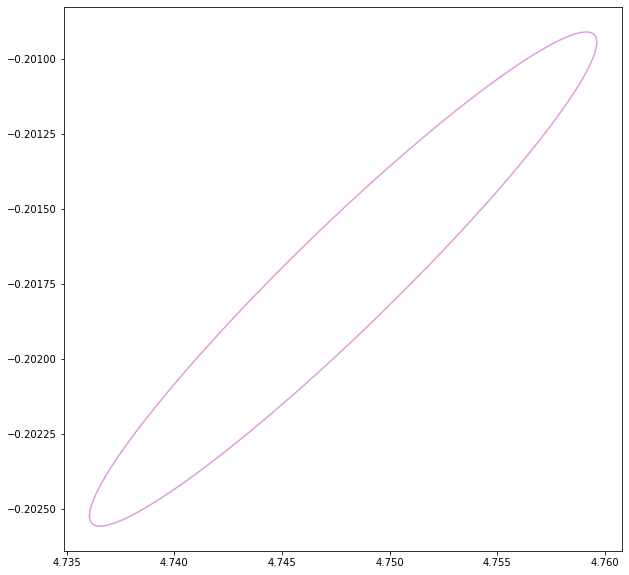

In [17]:
fig, ax = plt.subplots(figsize=(10,10))

get_cov_ellipse(np.array([[H1[0,0], H1[0,1]],[H1[1,0], H1[1,1]]]), [theta[0], theta[1]], 3, ax, 'plum')

In [18]:
print(Energies[-1])
print(A[-1])
print(Z[-1])
print(N[-1])

7.253774999999999
270
110


TypeError: 'int' object is not subscriptable

In [ ]:
start = 100
step = 5

#variables = np.concatenate((A[-noutputs:].reshape(-1,1),Z[-noutputs:].reshape(-1,1),\
                            #N[-noutputs:].reshape(-1,1)), axis=1)


variables = np.concatenate((A[start::step].reshape(-1,1),Z[start::step].reshape(-1,1),\
                            N[start::step].reshape(-1,1)), axis=1)

print(variables)